Found 27 .obj files
Processing 00156.obj...
Processing 00180.obj...
Processing 00169.obj...
Processing 00168.obj...
Processing 00154.obj...
Processing 00151.obj...
Processing 00179.obj...
Processing 00147.obj...
Processing 00152.obj...
Processing 00185.obj...
Processing 00135.obj...
Processing 00134.obj...
Processing 00122.obj...
Processing 00136.obj...
Processing 00137.obj...
Processing 00123.obj...
Processing 00127.obj...
Processing 00129.obj...
Processing 00163.obj...
Processing 00176.obj...
Processing 00160.obj...
Processing 00174.obj...
Processing 00148.obj...
Processing 00149.obj...
Processing 00175.obj...
Processing 00170.obj...
Processing 00167.obj...
Plot saved to /Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/height_vs_whr_plot.png
Measurements saved to /Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/body_measurements.csv


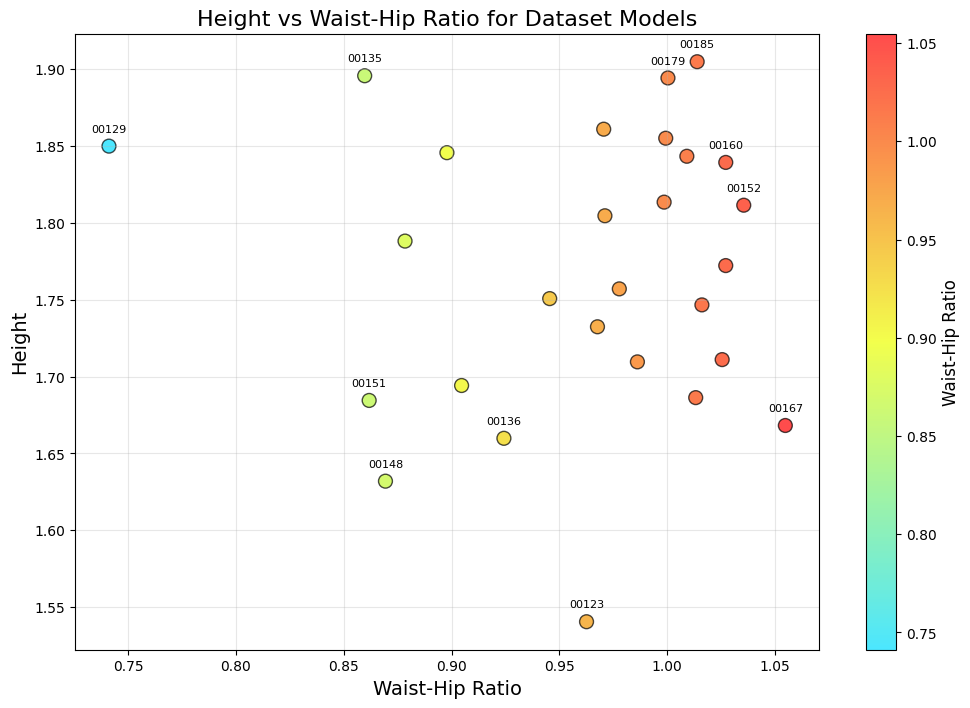

In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import trimesh
from scipy.spatial import ConvexHull
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

def calculate_body_measurements(obj_file):
    """
    Calculate height and waist-hip ratio for a 3D model
    
    Args:
        obj_file: Path to the .obj file
        
    Returns:
        tuple: (height, waist_hip_ratio, waist_circumference, hip_circumference)
    """
    try:
        # Load the mesh
        mesh = trimesh.load_mesh(obj_file)
        
        # Extract vertices
        vertices = np.array(mesh.vertices)
        
        # Calculate height (max y - min y)
        height = vertices[:, 1].max() - vertices[:, 1].min()
        
        # Determine vertical range for analysis
        y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
        
        # Define regions for waist and hip calculations
        # Waist is generally around 35-45% of height from bottom
        # Hip is generally around 25-35% of height from bottom
        waist_region_min = y_min + height * 0.35
        waist_region_max = y_min + height * 0.6
        hip_region_min = y_min + height * 0.25
        hip_region_max = y_min + height * 0.35
        
        # Calculate waist (minimum circumference in the waist region)
        waist_circumference = float('inf')
        waist_y = None
        
        # Calculate hip (maximum circumference in the hip region)
        hip_circumference = 0
        hip_y = None
        
        # Check horizontal slices at different heights
        num_slices = 50
        y_values = np.linspace(y_min, y_max, num_slices)
        
        for y in y_values:
            # Find vertices close to this horizontal slice (within a small tolerance)
            tolerance = height / 100  # 1% of height
            slice_indices = np.where(np.abs(vertices[:, 1] - y) < tolerance)[0]
            
            if len(slice_indices) < 3:
                continue  # Need at least 3 points for a valid slice
            
            # Project points to XZ plane
            slice_points = vertices[slice_indices][:, [0, 2]]  # Extract X and Z coordinates
            
            # Calculate circumference using the convex hull
            try:
                hull = ConvexHull(slice_points)
                circumference = hull.area
                
                # Check if this is in the waist region
                if waist_region_min <= y <= waist_region_max and circumference < waist_circumference:
                    waist_circumference = circumference
                    waist_y = y
                
                # Check if this is in the hip region
                if hip_region_min <= y <= hip_region_max and circumference > hip_circumference:
                    hip_circumference = circumference
                    hip_y = y
            except:
                # Skip if convex hull calculation fails
                continue
        
        # If waist or hip wasn't found in the expected regions, use best estimate
        if waist_circumference == float('inf'):
            # Find minimum circumference in the middle area of the model
            for y in y_values:
                if y_min + height * 0.3 <= y <= y_min + height * 0.7:  # Middle area
                    slice_indices = np.where(np.abs(vertices[:, 1] - y) < tolerance)[0]
                    if len(slice_indices) < 3:
                        continue
                    slice_points = vertices[slice_indices][:, [0, 2]]
                    try:
                        hull = ConvexHull(slice_points)
                        if hull.area < waist_circumference:
                            waist_circumference = hull.area
                    except:
                        continue
        
        if hip_circumference == 0:
            # Find maximum circumference in the lower area of the model
            for y in y_values:
                if y_min + height * 0.2 <= y <= y_min + height * 0.4:  # Lower area
                    slice_indices = np.where(np.abs(vertices[:, 1] - y) < tolerance)[0]
                    if len(slice_indices) < 3:
                        continue
                    slice_points = vertices[slice_indices][:, [0, 2]]
                    try:
                        hull = ConvexHull(slice_points)
                        if hull.area > hip_circumference:
                            hip_circumference = hull.area
                    except:
                        continue
        
        # Prevent division by zero
        if hip_circumference == 0:
            return height, None, waist_circumference, hip_circumference
        
        # Calculate waist-hip ratio
        waist_hip_ratio = waist_circumference / hip_circumference
        
        return height, waist_hip_ratio, waist_circumference, hip_circumference
    
    except Exception as e:
        print(f"Error processing {os.path.basename(obj_file)}: {str(e)}")
        return None, None, None, None

def visualize_body_dimensions(data_dir):
    """
    Create a scatter plot of height vs waist-hip ratio for all models in the directory
    
    Args:
        data_dir: Directory containing .obj files
    """
    # Find all .obj files
    obj_files = glob.glob(os.path.join(data_dir, "*.obj"))
    print(f"Found {len(obj_files)} .obj files")
    
    # Process each file
    results = []
    
    for obj_file in obj_files:
        print(f"Processing {os.path.basename(obj_file)}...")
        height, whr, waist, hip = calculate_body_measurements(obj_file)
        
        if height is not None and whr is not None:
            results.append({
                'filename': os.path.basename(obj_file),
                'height': height,
                'waist_hip_ratio': whr,
                'waist': waist,
                'hip': hip
            })
    
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(results)
    
    if df.empty:
        print("No valid measurements found.")
        return
    
    # Create custom colormap
    colors = ['#00DDFF', '#EEFF00', '#FF0000']
    cmap_name = 'custom_cmap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    
    # Create scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        df['waist_hip_ratio'], 
        df['height'], 
        c=df['waist_hip_ratio'],  # Color by waist-hip ratio
        cmap=cm,
        alpha=0.7,
        s=100,  # Point size
        edgecolors='black'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Waist-Hip Ratio', fontsize=12)
    
    # Add labels and title
    plt.xlabel('Waist-Hip Ratio', fontsize=14)
    plt.ylabel('Height', fontsize=14)
    plt.title('Height vs Waist-Hip Ratio for Dataset Models', fontsize=16)
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Add annotations for outliers or interesting points
    for _, row in df.iterrows():
        if row['waist_hip_ratio'] > np.percentile(df['waist_hip_ratio'], 90) or \
           row['waist_hip_ratio'] < np.percentile(df['waist_hip_ratio'], 10) or \
           row['height'] > np.percentile(df['height'], 90) or \
           row['height'] < np.percentile(df['height'], 10):
            plt.annotate(row['filename'][:-4], 
                        (row['waist_hip_ratio'], row['height']),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center',
                        fontsize=8)
    
    # Save plot
    output_dir = os.path.join(os.path.dirname(data_dir), "code/visuals")
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "height_vs_whr_plot.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    # Also save the measurements as CSV
    csv_path = os.path.join(output_dir, "body_measurements.csv")
    df.to_csv(csv_path, index=False)
    
    print(f"Plot saved to {output_path}")
    print(f"Measurements saved to {csv_path}")
    
    plt.show()

if __name__ == "__main__":
    data_directory = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/inner"
    visualize_body_dimensions(data_directory)

Found 11 missing values. Filling with column means.
Variance explained by PC1: 56.40%
Variance explained by PC2: 15.82%
Total variance explained: 72.22%
PCA plot saved to: /Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/pca_model_measurements.png


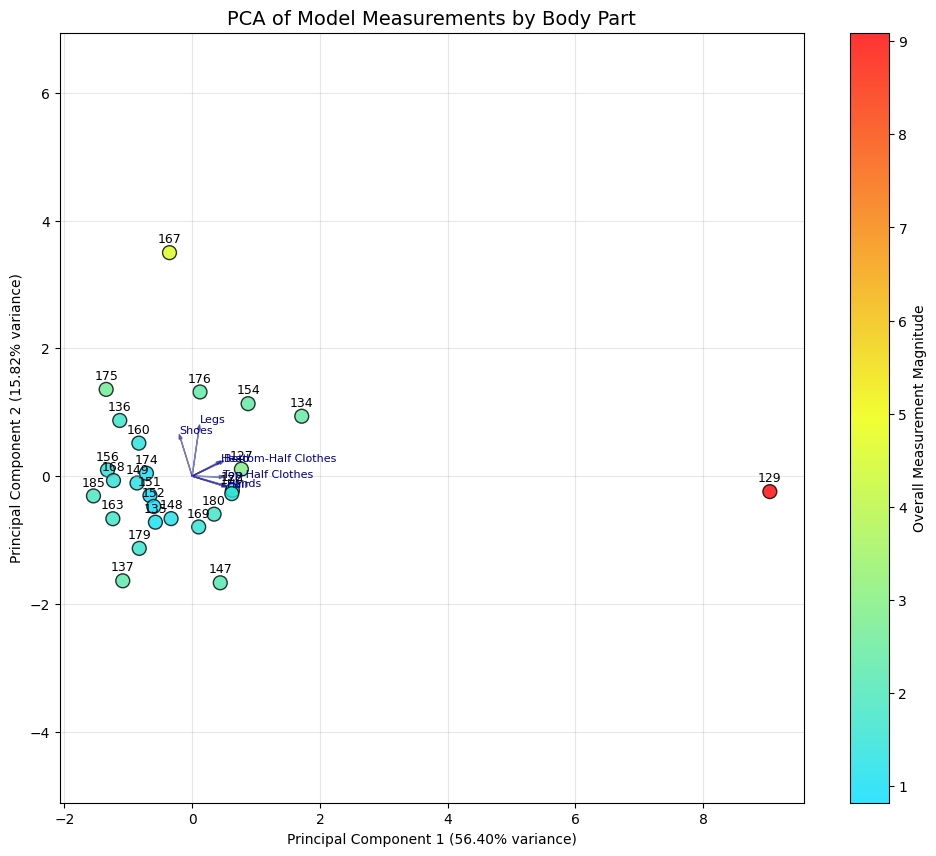

Correlation heatmap saved to: /Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/body_part_correlations.png


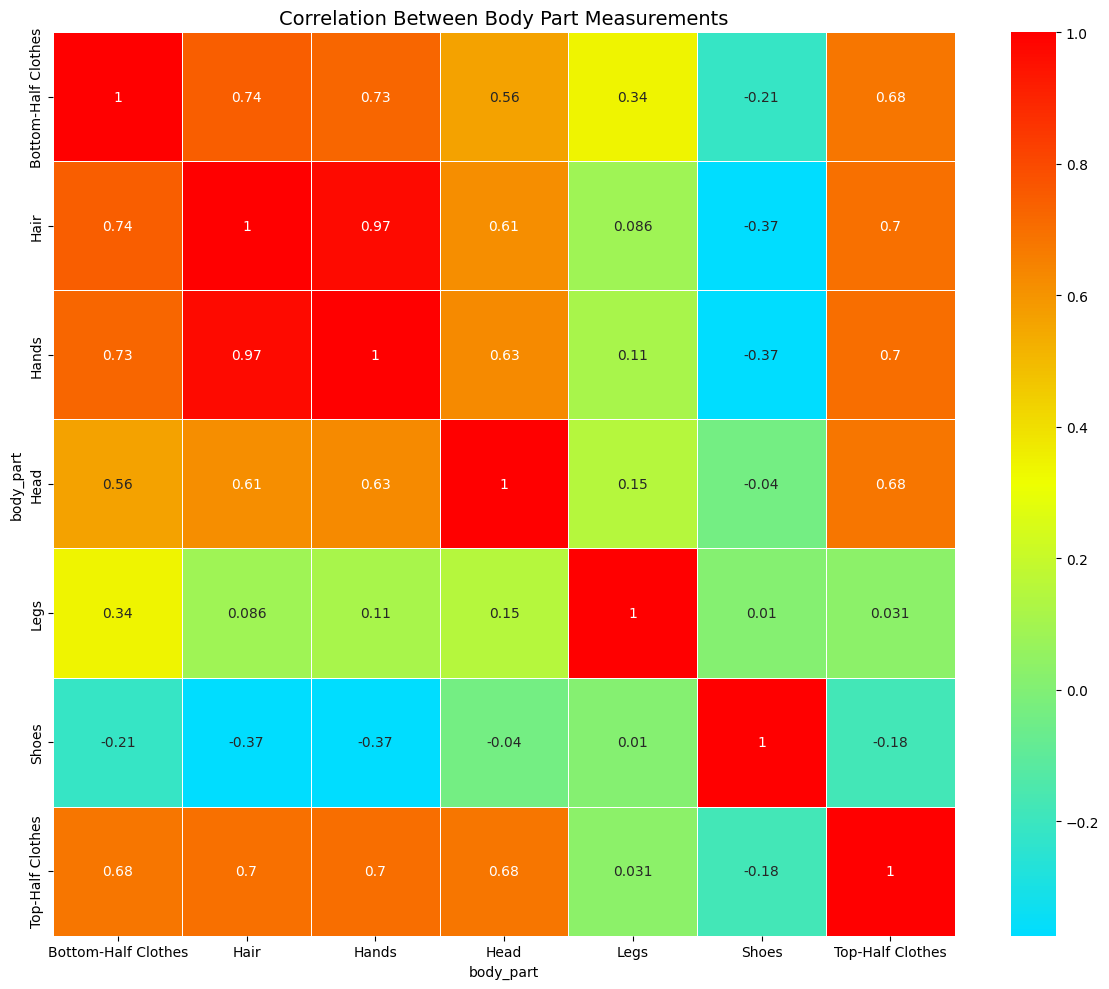

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

# Load the detailed measurements data
data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_labelled_files/analysis_results/detailed_distance_measurements.csv"
df = pd.read_csv(data_path)

# Filter out the 'overall' rows since we want per-body-part measurements
df_filtered = df[df['body_part'] != 'overall']

# Create a pivot table with models as rows and body parts as columns
# We'll use the mean values as our features
pivot_df = df_filtered.pivot_table(
    index='model_id',
    columns='body_part',
    values='mean'
)

# Check for any missing values and fill them if needed
if pivot_df.isna().any().any():
    print(f"Found {pivot_df.isna().sum().sum()} missing values. Filling with column means.")
    pivot_df = pivot_df.fillna(pivot_df.mean())

# Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Apply PCA
n_components = 2  # We'll use 2 for visualization
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_result,
    columns=['PC1', 'PC2'],
    index=pivot_df.index
)

# Calculate the variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {explained_variance[0]:.2%}")
print(f"Variance explained by PC2: {explained_variance[1]:.2%}")
print(f"Total variance explained: {sum(explained_variance):.2%}")

# Create custom colormap
colors = ['#00DDFF', '#EEFF00', '#FF0000']
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Visualize the results using a scatter plot
plt.figure(figsize=(12, 10))

# Create the scatter plot
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'],
    c=np.linalg.norm(scaled_data, axis=1),  # Color by overall magnitude of measurements
    cmap=cm,
    alpha=0.8,
    s=100,
    edgecolors='black'
)

# Add labels for each point
for model_id in pca_df.index:
    plt.annotate(
        model_id,
        (pca_df.loc[model_id, 'PC1'], pca_df.loc[model_id, 'PC2']),
        fontsize=9,
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

# Plot the feature loadings (contribution of each original variable to PCs)
feature_names = pivot_df.columns
loadings = pca.components_.T
max_arrow_length = 1.0  # Scaling factor for arrows

for i, feature in enumerate(feature_names):
    plt.arrow(
        0, 0,  # Start at origin
        loadings[i, 0] * max_arrow_length,  # PC1 loading
        loadings[i, 1] * max_arrow_length,  # PC2 loading
        color='darkblue',
        alpha=0.5,
        head_width=0.05
    )
    plt.text(
        loadings[i, 0] * max_arrow_length * 1.15,
        loadings[i, 1] * max_arrow_length * 1.15,
        feature,
        color='darkblue',
        fontsize=8
    )

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Overall Measurement Magnitude')

# Add labels and title
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} variance)')
plt.title('PCA of Model Measurements by Body Part', fontsize=14)

# Add a grid
plt.grid(True, alpha=0.3)

# Add an equal aspect ratio for better visualization
plt.axis('equal')

# Save the plot
output_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/pca_model_measurements.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"PCA plot saved to: {output_path}")
plt.show()

# Bonus: Create a heatmap showing the correlation between body parts
plt.figure(figsize=(12, 10))
correlation_matrix = pivot_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=cm, linewidths=0.5)
plt.title('Correlation Between Body Part Measurements', fontsize=14)
plt.tight_layout()

# Save the correlation heatmap
corr_output_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/body_part_correlations.png"
plt.savefig(corr_output_path, dpi=300, bbox_inches='tight')

print(f"Correlation heatmap saved to: {corr_output_path}")
plt.show()

Body measurements dataset contains 27 models
Distance measurements dataset contains 26 models
Body measurements model IDs: ['00156', '00180', '00169', '00168', '00154'] ...
Updated distance measurements model IDs: ['00122', '00127', '00129', '00134', '00135'] ...
Found 26 common model IDs between datasets
Merged dataset contains 26 models
Plot saved to: /Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/height_whr_distance.png
Correlation heatmap saved to: /Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/measurement_correlation_heatmap.png


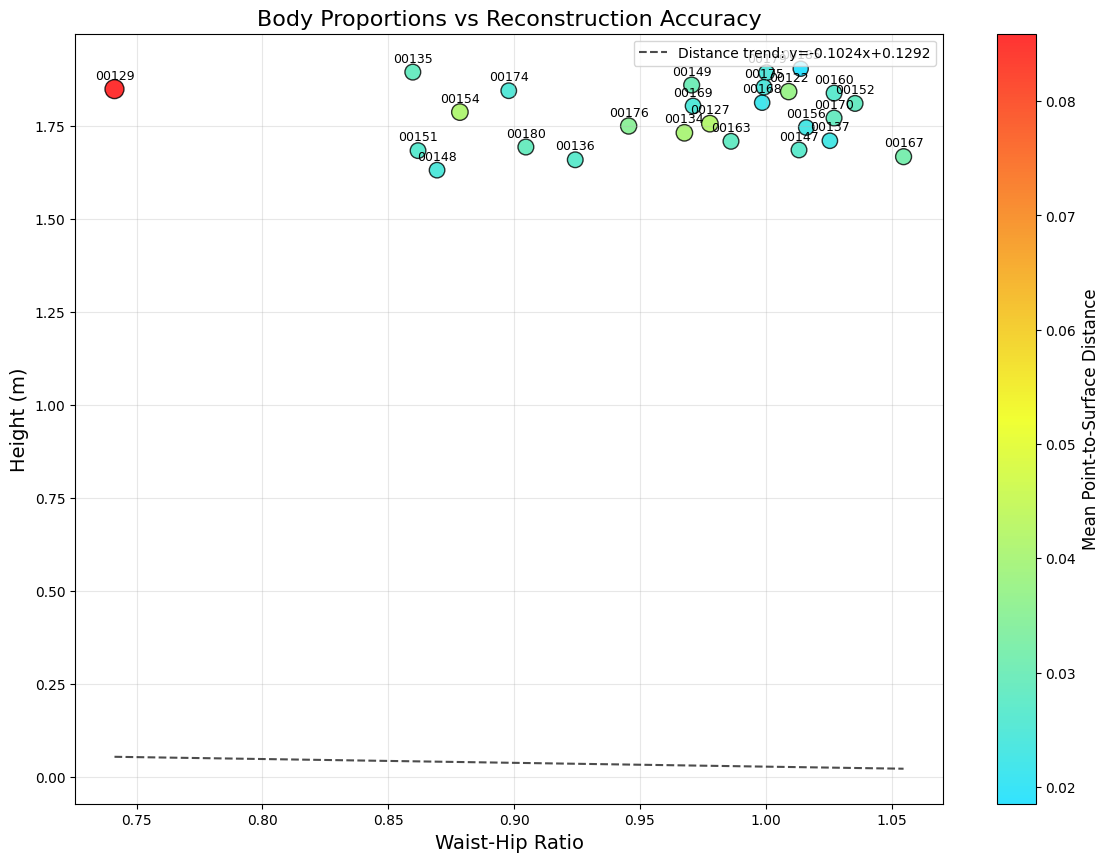

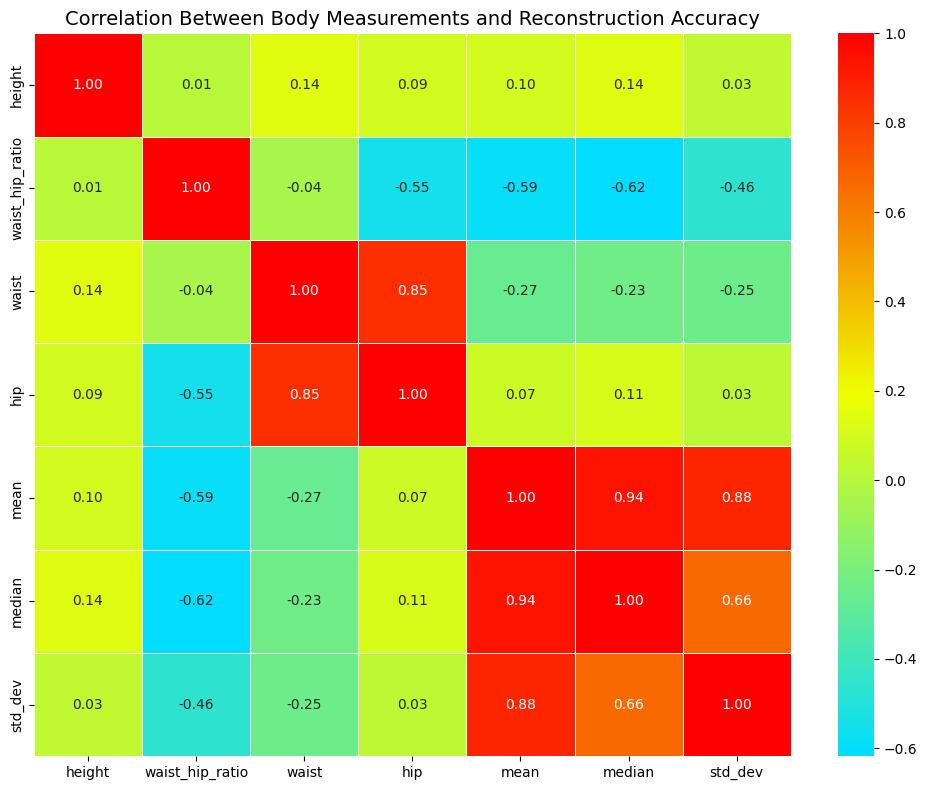

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Load datasets
body_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/body_measurements.csv"
body_df = pd.read_csv(body_data_path)
body_df['model_id'] = body_df['filename'].str.split('.').str[0]

distance_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_labelled_files/analysis_results/detailed_distance_measurements.csv"
distance_df = pd.read_csv(distance_data_path)
overall_df = distance_df[distance_df['body_part'] == 'overall'].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Fix the model_id format in distance measurements to match body measurements
# Add leading zeros to match the "00XXX" format
overall_df['model_id'] = overall_df['model_id'].astype(str).apply(lambda x: f"00{x}" if len(x) == 3 else f"0{x}" if len(x) == 4 else x)

print(f"Body measurements dataset contains {len(body_df)} models")
print(f"Distance measurements dataset contains {len(overall_df)} models")
print("Body measurements model IDs:", body_df['model_id'].tolist()[:5], "...")  
print("Updated distance measurements model IDs:", overall_df['model_id'].tolist()[:5], "...")

# Check for common model IDs after format correction
common_ids = set(body_df['model_id']).intersection(set(overall_df['model_id']))
print(f"Found {len(common_ids)} common model IDs between datasets")

# Merge datasets
merged_df = pd.merge(body_df, overall_df, on='model_id', how='inner')
print(f"Merged dataset contains {len(merged_df)} models")

# Create visualization
if len(merged_df) > 0:
    # Create custom colormap
    colors = ['#00DDFF', '#EEFF00', '#FF0000']
    cmap_name = 'custom_cmap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    
    # Create figure
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot
    scatter = plt.scatter(
        merged_df['waist_hip_ratio'], 
        merged_df['height'],
        c=merged_df['mean'],  # Color by mean distance
        cmap=cm,
        s=100 + merged_df['mean'] * 1000,  # Size also reflects mean distance
        alpha=0.8,
        edgecolors='black'
    )
    
    # Add labels for each point
    for _, row in merged_df.iterrows():
        plt.annotate(
            row['model_id'],
            (row['waist_hip_ratio'], row['height']),
            fontsize=9,
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mean Point-to-Surface Distance', fontsize=12)
    
    # Add labels and title
    plt.xlabel('Waist-Hip Ratio', fontsize=14)
    plt.ylabel('Height (m)', fontsize=14)
    plt.title('Body Proportions vs Reconstruction Accuracy', fontsize=16)
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Calculate and plot trend line
    if len(merged_df) >= 2:
        z = np.polyfit(merged_df['waist_hip_ratio'], merged_df['mean'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(merged_df['waist_hip_ratio']), p(sorted(merged_df['waist_hip_ratio'])), 
                 "k--", alpha=0.7, label=f"Distance trend: y={z[0]:.4f}x+{z[1]:.4f}")
        plt.legend(loc='upper right')
    
    # Save plot
    output_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/height_whr_distance.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_path}")
    
    # Create correlation heatmap if we have enough data points
    if len(merged_df) >= 3:
        plt.figure(figsize=(10, 8))
        correlation_cols = ['height', 'waist_hip_ratio', 'waist', 'hip', 'mean', 'median', 'std_dev']
        corr_matrix = merged_df[correlation_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap=cm, fmt=".2f", linewidths=0.5)
        plt.title('Correlation Between Body Measurements and Reconstruction Accuracy', fontsize=14)
        plt.tight_layout()
        
        corr_output_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/measurement_correlation_heatmap.png"
        plt.savefig(corr_output_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap saved to: {corr_output_path}")
else:
    print("No matching models found after ID correction. Please check the data.")